# Implementation of spaCy  for NER(Trained on GPU)

In [105]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random
from sklearn.feature_extraction import DictVectorizer
import pprint
pp = pprint.PrettyPrinter(indent=4)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import scipy.stats
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding,decaying
from spacy.scorer import Scorer
import tensorflow as tf
from tensorflow.keras import optimizers
import keras
from keras_radam import RAdam
from sklearn_crfsuite.metrics import flat_classification_report
spacy.prefer_gpu()

True

In [2]:
spacy.require_gpu()


True

In [40]:
data = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
data.dropna(inplace=True)
df=pd.DataFrame({'word':data.word,'tag':data.tag,'pos':data.pos})
df.reset_index(drop=True,inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


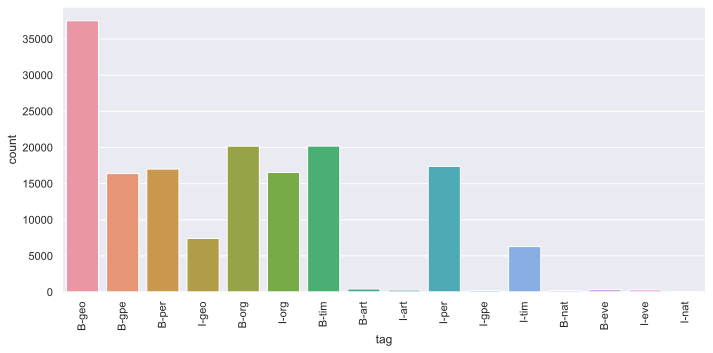

In [4]:
plt.figure(figsize=(10,5))
ax = sns.countplot('tag', data=df.loc[df['tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# spaCy

In [57]:
converted_data = []
i = 0
cnt = 0
while i < len(df):
    sentence = None
    lngth = 0  #To keep track of length of sentence upto current word
    ls = []
    dct = {}
    while (i + 1 < len(df)) & (df.word[i] != '.'):
        if lngth == 0:
            sentence = df.word[i]
        else:
            sentence = sentence + " " + df.word[i]
        start = lngth
        end = start + len(df.word[i])
        assert len(df.word[i]) == end - start
        try:
            if df.tag[i]!='O':
                ls.append(tuple([start, end, df.tag[i]]))
            else:
                continue
        finally:
            lngth = lngth + len(df.word[i])
            i += 1
    dct['entities'] = ls
    cnt += len(list(dct.values())[0])
    try:
        if sentence == None:
            continue
        else:
            converted_data.append((sentence, dct))
    finally:
        i += 1

In [71]:

def custom_optimizer(optimizer, learn_rate=0.01, beta1=0.9, beta2=0.999, eps=1e-8, L2=1e-6, max_grad_norm=1.0):
    
    optimizer.learn_rate = learn_rate
    optimizer.beta1 = beta1
    optimizer.beta2 = beta2
    optimizer.eps = eps
    optimizer.L2 = L2
    optimizer.max_grad_norm = max_grad_norm
    
    return optimizer

In [78]:
def model(train_data,
          model=None,
          output_dir='model_NER',
          n_iter=30,
          learn_rate=0.01,
          beta1=0.9,
          beta2=0.999,
          eps=1e-8,
          L2=1e-6,
          max_grad_norm=1.0):

    if model is not None:
        nlp = spacy.load(model)
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")
        print("Created blank 'en' model")

    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)

    else:
        ner = nlp.get_pipe("ner")

    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [
        pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions
    ]

    with nlp.disable_pipes(*other_pipes) and warnings.catch_warnings():
        warnings.filterwarnings("once", category=UserWarning, module='spacy')

        dropout = decaying(0.6, 0.2, 1e-4)

        if model is None:
            optimizer = nlp.begin_training(
                component_cfg={
                    "ner": {
                        "beam_width": 2,
                        "token_vector_width": 96,
                        "conv_window": 3
                    }
                })

            optimizer = custom_optimizer(optimizer, learn_rate=learn_rate)

        for itn in range(n_iter):
            random.shuffle(train_data)
            losses = {}

            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,
                           annotations,
                           drop=next(dropout),
                           losses=losses,
                           sgd=optimizer)
            print(" Losses {} ,Iteration {} ".format(losses, itn))

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        with nlp.use_params(optimizer.averages):
            nlp.to_disk(output_dir)
            print("Saved model to", output_dir)

All possible parameters of component_cfg :
"beam_width":1,
"beam_density":0.0,
"beam_update_prob":1.0,
"cnn_maxout_pieces":3,
"nr_feature_tokens":6,
"nr_class":10,
"hidden_depth":1,
"token_vector_width":96,
"hidden_width":64,
"maxout_pieces":2,
"pretrained_vectors":null,
"bilstm_depth":0,
"self_attn_depth":0,
"conv_depth":4,
"conv_window":3,
"embed_size":2000

In [79]:
train_data=converted_data[:43000]
test_data=converted_data[43000:]

In [80]:
model(train_data[:43000]) 

Created blank 'en' model
 Losses {'ner': 24061.49152400357} ,Iteration 0 
 Losses {'ner': 13720.26729776385} ,Iteration 1 
 Losses {'ner': 13203.366484866103} ,Iteration 2 
 Losses {'ner': 13603.918012768516} ,Iteration 3 
 Losses {'ner': 13205.594405512133} ,Iteration 4 
 Losses {'ner': 14248.291347258508} ,Iteration 5 
 Losses {'ner': 13791.64149170318} ,Iteration 6 
 Losses {'ner': 13309.177288468056} ,Iteration 7 
 Losses {'ner': 13286.460954225331} ,Iteration 8 
 Losses {'ner': 13398.935497966277} ,Iteration 9 
 Losses {'ner': 13453.479063703153} ,Iteration 10 
 Losses {'ner': 13105.733154358335} ,Iteration 11 
 Losses {'ner': 12904.743633982645} ,Iteration 12 
 Losses {'ner': 13676.218799291075} ,Iteration 13 
 Losses {'ner': 13034.14352302115} ,Iteration 14 
 Losses {'ner': 13239.313517914963} ,Iteration 15 
 Losses {'ner': 12823.809419515102} ,Iteration 16 
 Losses {'ner': 13304.06501196148} ,Iteration 17 
 Losses {'ner': 13046.012985767014} ,Iteration 18 
 Losses {'ner': 13273

In [90]:
print("Loading from",'model_NER' )
nlp = spacy.load('model_NER')

Loading from model_NER


In [99]:
doc =nlp(converted_data[44032][0])
for ents in doc.ents:
    print(ents.label_,ents.text)

B-geo Venezuela


In [107]:
scorer = nlp.evaluate(test_data, verbose=False)
print(scorer.scores)   

{'uas': 0.0, 'las': 0.0, 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}}, 'ents_p': 76.77419354838709, 'ents_r': 71.25748502994011, 'ents_f': 73.91304347826086, 'ents_per_type': {'B-geo': {'p': 76.11940298507463, 'r': 83.60655737704919, 'f': 79.6875}, 'B-gpe': {'p': 97.36842105263158, 'r': 82.22222222222221, 'f': 89.1566265060241}, 'B-org': {'p': 64.51612903225806, 'r': 58.82352941176471, 'f': 61.53846153846154}, 'B-per': {'p': 52.94117647058824, 'r': 47.368421052631575, 'f': 50.0}, 'B-tim': {'p': 100.0, 'r': 25.0, 'f': 40.0}}, 'tags_acc': 0.0, 'token_acc': 100.0, 'textcat_score': 0.0, 'textcats_per_cat': {}}
